# Construct integrated data matrices

This in vivo mouse data analysis pipeline integrates data across mono-colonization, community, and conventional mice experiments and three analytical methods to generate a unified, metabolite fold-change matrix. 

First, the mouse sample database and MS-DIAL analysis files from all experiments are parsed and integrated into a single data matrix of raw ion counts across the three analytical methods (referred to as "modes" below). 

Next, a shared set of robustly detected internal standards among different experients are used to normalize across experiments to account for inter-experimental variations in instrumental sensitivity. Specifically, the raw ion count from each metabolite is normalized to the sum of internal standards specific to each experiment (e.g. community experiment) and sample type (e.g. serum). 

Lastly, the fold change matrix is generated next by calculating the relative fold change between metabolite ion counts detected in colonized mice vs. germ-free controls for each experiment and sample type. A separate metadata file is also generated to detail the associated metadata properties of each sample run in each mode.

There are two independent sets of analysis conducted. The final output matrices in the supplementary table join results from these two analyses:
1) The original submission data analysis includes Bacteroides thetaiotaomicron, Clostridium sporogenes, multi-member colonization and conventional mouse data. These data are used to generate Fig. 4 and the associated Extended Data Fig. 7.
2) The new revision data analysis includes the new Citrobacter portuclensis and Anaerostipes sp. mono-colonization mouse data. These data are used to generate the new Fig. 4a, and new Extended Data Fig. 7a.

See supporting code in `mouse_data_analysis.py`.


In [1]:
import numpy as np
import pandas as pd
import os
from mouse_data_analysis import MouseDataAnalysis

non_community_db = pd.concat([
    pd.read_excel('input/Supplementary_Table_8_in_vivo_db_data_matricies.xlsx', sheet_name='db_mono-colonization').set_index('run_id'),
    pd.read_excel('input/Supplementary_Table_8_in_vivo_db_data_matricies.xlsx', sheet_name='db_conventional').set_index('run_id')
], sort=True)

non_community_db = non_community_db[non_community_db['colonization'].notna()]

community_db = pd.read_excel('input/Supplementary_Table_8_in_vivo_db_data_matricies.xlsx',
                             sheet_name='db_community',
                             dtype={'tissue_measurement': str}) \
    .set_index('run_id')



msdial_analysis_map = pd.read_excel('input/experiment_to_msdial_data_map_in_vivo.xlsx')
msdial_analysis_dir = os.path.dirname('input/experiment_to_msdial_data_map_in_vivo.xlsx')

cpd_library = pd.read_excel('input/Supplementary_Table_1_mz-rt_library.xlsx', 
                            sheet_name='chemical_info')

original_submission_data_analysis = MouseDataAnalysis(
    non_community_db[non_community_db['experiment'] != 'mono-colonization_2'],
    community_db,
    msdial_analysis_map[msdial_analysis_map['experiment'] != 'mono-colonization_2'],
    msdial_analysis_dir,
    cpd_library
)

# Generate matrices with columns as dnames for both sets of data analysis:
# The original submission data includes Bacteroides thetaiotaomicron, 
# Clostridium sporogenes, multi-member colonization and conventional mouse data.
# The new revision data includes the new Citrobacter portuclensis and Anaerostipes sp. mono-colonization mouse data

original_submission_result_dnames = original_submission_data_analysis.run(
    collapse_mouse_ids=True, 
    output_cpd_names=False, 
    remove_dnames=True
)

new_revision_data_analysis = MouseDataAnalysis(
    non_community_db[non_community_db['experiment'] == 'mono-colonization_2'],
    community_db,
    msdial_analysis_map[msdial_analysis_map['experiment'] == 'mono-colonization_2'],
    msdial_analysis_dir,
    cpd_library
)

new_revision_result_dnames = new_revision_data_analysis.run(
    collapse_mouse_ids=True, 
    output_cpd_names=False, 
    remove_dnames=True
)

# Concatenate all data output from both original submission and new revision datasets
# for reporting in supplementary table

metadata_combined = pd.concat([
    original_submission_result_dnames['metadata'],
    new_revision_result_dnames['metadata']
])

metadata_combined.to_csv('metadata.txt', sep='\t')

pd.concat([
    original_submission_result_dnames['raw_ion_counts_matrix'],
    new_revision_result_dnames['raw_ion_counts_matrix']
]).to_csv('raw_ion_counts_matrix.txt', sep='\t')

pd.concat([
    original_submission_result_dnames['istd_corrected_matrix'],
    new_revision_result_dnames['istd_corrected_matrix']
]).to_csv('istd_corrected_matrix.txt', sep='\t')

pd.concat([
    original_submission_result_dnames['fold_change_matrix'],
    new_revision_result_dnames['fold_change_matrix']
]).to_csv('fold_change_matrix.txt', sep='\t')

pd.concat([
    original_submission_result_dnames['fold_change_replicates_collapsed_matrix'],
    new_revision_result_dnames['fold_change_replicates_collapsed_matrix']
]).to_csv('fold_change_replicates_collapsed_matrix.txt', sep='\t')

# Generate matrices with columns as compound names for plotting purposes
original_submission_result = original_submission_data_analysis.run(
    collapse_mouse_ids=True, 
    output_cpd_names=True, 
    remove_dnames=True
)

metadata = original_submission_result['metadata']

new_revision_result = new_revision_data_analysis.run(
    collapse_mouse_ids=True, 
    output_cpd_names=True, 
    remove_dnames=True
)

fold_change_matrix_combined = pd.concat([
    original_submission_result['fold_change_matrix'],
    new_revision_result['fold_change_matrix']
])

In [2]:
metadata_combined

,experiment,sample_type,colonization,c18positive,c18negative,hilicpositive,mouse_id,tissue_measurement
sample_id,,,,,,,,
s0022,community,feces,germ-free,c0005,c0006,c0004,NaN,None
s0029,community,feces,germ-free,c0020,c0021,c0019,NaN,None
s0034,community,feces,germ-free,c0035,c0036,c0034,NaN,None
s0054,community,feces,Bt_Ca_Er_Pd_Et,c0071,c0072,c0070,NaN,None
s0070,community,feces,Bt_Ca_Er_Pd_Et,c0086,c0087,c0085,NaN,None
...,...,...,...,...,...,...,...,...
s1193,mono-colonization_2,serum,Cp,m0454,m0518,m0582,NaN,NaN
s1194,mono-colonization_2,serum,Cp,m0455,m0519,m0583,NaN,NaN
s1195,mono-colonization_2,serum,Cp,m0456,m0520,m0584,NaN,NaN


In [3]:
fold_change_matrix_combined

,"1,2-DIDECANOYL-SN-GLYCERO-3-PHOSPHOCHOLINE.hilicpositive","1,3-DIAMINOPROPANE.c18positive","1,5,6,7-TETRAHYDRO-4H-INDOL-4-ONE, 2-PHENYLACETAMIDE, N-BENZYLFORMAMIDE.hilicpositive","1,5,6,7-TETRAHYDRO-4H-INDOL-4-ONE.c18positive","1,5-ANHYDRO-GLUCITOL.c18negative","1,5-ANHYDRO-GLUCITOL.c18positive","1,6-ANHYDRO-B-GLUCOSE.c18negative","1,6-ANHYDRO-B-GLUCOSE.c18positive",1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID.c18positive,1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID.hilicpositive,...,SACCHARIN.c18positive,SELENOMETHIONINE.c18positive,SORBIC ACID.hilicpositive,SUBERIC ACID.hilicpositive,SUBERYL GLYCINE.hilicpositive,TAUROLITHOCHOLIC ACID.c18negative,TERPINEN-4-OL.c18negative,THIAMINE MONOPHOSPHATE.c18positive,THYROXINE.c18positive,VALPROIC ACID.c18negative
sample_id,,,,,,,,,,,,,,,,,,,,,
s0022,NaN,NaN,NaN,-0.383166,NaN,NaN,0.256161,0.200663,0.579455,0.888962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s0029,NaN,NaN,NaN,-0.587809,NaN,NaN,0.241190,-0.110810,-0.227751,-0.530462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s0034,NaN,NaN,NaN,0.648828,NaN,NaN,-0.680991,-0.112934,-0.617609,-1.133450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s0054,NaN,NaN,NaN,0.480123,NaN,NaN,1.191450,-3.414069,-0.380212,-1.845688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s0070,NaN,NaN,NaN,0.459749,NaN,NaN,0.045474,-3.197686,-0.455812,-2.186697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s1193,NaN,NaN,NaN,NaN,0.392379,NaN,NaN,-0.863059,-0.474356,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s1194,NaN,NaN,NaN,NaN,-0.179876,NaN,NaN,-0.651162,-0.130467,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s1195,NaN,NaN,NaN,NaN,-0.584801,NaN,NaN,-0.217961,-0.552064,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Join metabolite data collected by three analytical methods

When a metabolite is detected by multiple analytical methods ("modes"), its fold-change values are averaged among the preferred detection modes, which are determined based on the consistency (CVs) of detection among bioloical replicates for each mode. Using "mode_picking_in_vivo.xlsx" that has been generated based on the manual inspection of detection consistency, on a per-metabolite and per-mode basis, we can pick the best mode or average the data between multiple well-performing modes for each metabolite.


In [4]:
mode_picker = pd.read_excel('input/mode_picking_in_vivo.xlsx', 
                            index_col=0, 
                            sheet_name='in_vivo')

analysis = MouseDataAnalysis()

# Collapse modes for the combined datasets for reporting in supplementary table
analysis.collapse_modes(
    fold_change_matrix_combined, 
    mode_picker
).to_csv('fold_change_matrix_mode_collapsed.txt', sep='\t')

# Collapse modes for the original submission dataset (to be used in the rest of the notebook)
fold_change_matrix_mode_collapsed = analysis.collapse_modes(
    original_submission_result['fold_change_matrix'], 
    mode_picker
)

In [5]:
fold_change_matrix_mode_collapsed

,"1,2-DIDECANOYL-SN-GLYCERO-3-PHOSPHOCHOLINE","1,3-DIAMINOPROPANE","1,5,6,7-TETRAHYDRO-4H-INDOL-4-ONE","1,5,6,7-TETRAHYDRO-4H-INDOL-4-ONE, 2-PHENYLACETAMIDE, N-BENZYLFORMAMIDE","1,5-ANHYDRO-GLUCITOL","1,6-ANHYDRO-B-GLUCOSE",1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID,"1-METHYL-6,7-DIHYDROXY-1,2,3,4-TETRAHYDROISOQUINOLINE",1-METHYL-HYDANTOIN,1-METHYLADENOSINE,...,URIDINE,UROCANIC ACID,URSOCHOLIC ACID,VALINE,VANILLIC ACID,VANILLIN,VITAMIN D3,XANTHINE,XANTHOSINE,XANTHURENIC ACID
sample_id,,,,,,,,,,,,,,,,,,,,,
s0022,NaN,NaN,-0.383166,NaN,NaN,0.228679,0.579455,NaN,NaN,0.664009,...,0.819210,0.586411,0.951691,NaN,NaN,NaN,NaN,NaN,NaN,1.502982
s0029,NaN,NaN,-0.587809,NaN,NaN,0.075899,-0.227751,NaN,NaN,-0.739448,...,-0.274363,-0.397586,-0.762709,NaN,NaN,NaN,NaN,NaN,NaN,-2.642760
s0034,NaN,NaN,0.648828,NaN,NaN,-0.369183,-0.617609,NaN,NaN,-0.292382,...,-1.290724,-0.435639,-1.069536,NaN,NaN,NaN,NaN,NaN,NaN,-7.480627
s0054,NaN,NaN,0.480123,NaN,NaN,0.249527,-0.380212,NaN,NaN,-1.073841,...,-1.213943,2.603144,2.939917,NaN,NaN,NaN,NaN,NaN,NaN,7.438369
s0070,NaN,NaN,0.459749,NaN,NaN,-0.809681,-0.455812,NaN,NaN,-0.249821,...,-1.350947,2.135132,2.747299,NaN,NaN,NaN,NaN,NaN,NaN,6.218337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s1073,NaN,4.664192,1.729897,NaN,NaN,-1.005848,1.070302,NaN,4.686384,NaN,...,0.337042,-1.474039,10.304651,-0.863520,-0.838321,NaN,NaN,2.950291,1.207594,2.761734
s1074,NaN,4.485271,1.591258,NaN,NaN,-0.473267,0.956464,NaN,4.454024,NaN,...,0.101765,-0.965399,10.517827,-0.008474,-1.117990,NaN,NaN,3.135059,0.777917,2.898386
s1075,NaN,3.488363,2.617863,NaN,NaN,-1.136146,0.867009,NaN,5.312558,NaN,...,-1.892278,-13.092776,7.279887,0.935364,-0.242007,NaN,NaN,0.387236,-2.401387,4.589260


# Principal Component Analysis (PCA)

PCA analyses are conducted to examine whether distinct sample types or colonization states can be separated by their metabolomic profiles. See the supporting code in `pcaplot.py`.

Sample types:

- serum
- urine
- cecal (or "caecal") contents;
- feces

Colonization states: 

- Germ-free controls
- Clostridium sporogenes (Cs) ATCC 15579
- Bacteroides thetaiotaomicron (Bt) VPI 5482
- Six-member community
  - Clostridium sporogenes ATCC 15579
  - Bacteroides thetaiotaomicron VPI 5482
  - Edwardsiella tarda ATCC 23685
  - Collinsella aerofaciens ATCC 25986
  - Eubacterium rectale ATCC 33656
  - Parabacteroides distasonis ATCC 8503
- Five-member community
  - Bacteroides thetaiotaomicron VPI 5482
  - Edwardsiella tarda ATCC 23685
  - Collinsella aerofaciens ATCC 25986
  - Eubacterium rectale ATCC 33656
  - Parabacteroides distasonis ATCC 8503


In [6]:
%matplotlib inline

from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import euclidean

from pcaplot import PCAPlot

def get_distance_matrix(fc_matrix):
    num_rows = len(fc_matrix)

    dist_matrix = np.zeros((num_rows, num_rows), dtype=float)

    for i in range(num_rows):
        row_i = fc_matrix.iloc[i]
        nans_i = np.isnan(row_i.values)

        for j in range(num_rows):
            row_j = fc_matrix.iloc[j]
            nans_j = np.isnan(row_j.values)

            combined_nans = nans_i | nans_j

            row_i_no_nans = row_i[~combined_nans]
            row_j_no_nans = row_j[~combined_nans]

            dist_matrix[i, j] = euclidean(row_i_no_nans, row_j_no_nans)

    return dist_matrix

def calculate_permanova(fc_matrix, metadata, colonizations, sample_types):
    if len(colonizations) > 1 and len(sample_types) > 1:
        raise Exception('Can only compare colonizations or sample types')

    fc_matrix = fc_matrix \
        .join(metadata[['experiment', 'sample_type', 'colonization']])

    fc_matrix = fc_matrix[
        (fc_matrix['sample_type'].isin(sample_types)) &
        (fc_matrix['colonization'].isin(colonizations))
    ]

    feature_matrix = fc_matrix \
        .drop(columns=['experiment', 'colonization', 'sample_type'])

    grouping_col = 'sample_type' if len(colonizations) == 1 else 'colonization'
    grouping_values = fc_matrix[grouping_col].values

    dist_matrix = get_distance_matrix(feature_matrix)

    return permanova(DistanceMatrix(dist_matrix), grouping_values)

### PCA: separation by sample types of mice mono-associated with Clostridium sporogenes (Cs)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd00a57890>)

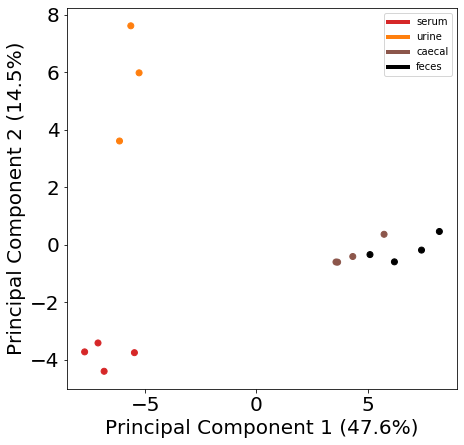

In [7]:
pcaplot = PCAPlot(fold_change_matrix_mode_collapsed, 
                  metadata, 
                  ['Cs'], 
                  ['serum', 'urine', 'caecal', 'feces'])

pcaplot.plot_components([1, 2])

In [8]:
calculate_permanova(fold_change_matrix_mode_collapsed, 
                    metadata, 
                    ['Cs'], 
                    ['serum', 'urine', 'caecal', 'feces'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      15
number of groups                  4
test statistic             6.612836
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

### PCA: separation by sample types of mice mono-associated with Bacteroides thetaioaomicron (Bt)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd40f75ad0>)

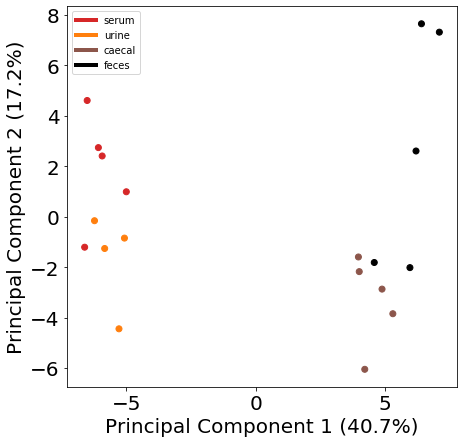

In [9]:
pcaplot = PCAPlot(fold_change_matrix_mode_collapsed, 
                  metadata, 
                  ['Bt'], 
                  ['serum', 'urine', 'caecal', 'feces'])

pcaplot.plot_components([1, 2])

In [10]:
calculate_permanova(fold_change_matrix_mode_collapsed, 
                    metadata, 
                    ['Bt'], 
                    ['serum', 'urine', 'caecal', 'feces'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      19
number of groups                  4
test statistic             4.090124
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

### PCA: separation by sample types of mice colonized with a six-member community

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcf1827a50>)

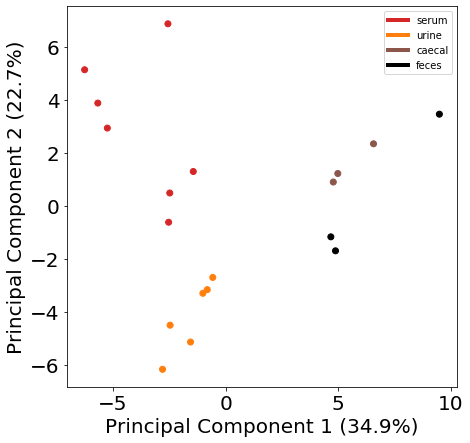

In [11]:
pcaplot = PCAPlot(fold_change_matrix_mode_collapsed, 
                  metadata, 
                  ['Cs_Bt_Ca_Er_Pd_Et'], 
                  ['serum', 'urine', 'caecal', 'feces'])

pcaplot.plot_components([1, 2])

In [31]:
calculate_permanova(fold_change_matrix_mode_collapsed, 
                    metadata, 
                    ['Cs_Bt_Ca_Er_Pd_Et'], 
                    ['serum', 'urine', 'caecal', 'feces'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      19
number of groups                  4
test statistic             1.647849
p-value                       0.073
number of permutations          999
Name: PERMANOVA results, dtype: object

### PCA: separation by sample types of mice colonized with a five-member community

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdce13c9550>)

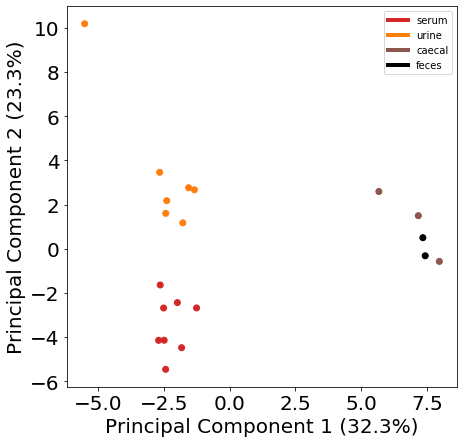

In [13]:
pcaplot = PCAPlot(fold_change_matrix_mode_collapsed, 
                  metadata, 
                  ['Bt_Ca_Er_Pd_Et'], 
                  ['serum', 'urine', 'caecal', 'feces'])

pcaplot.plot_components([1, 2])

In [14]:
calculate_permanova(fold_change_matrix_mode_collapsed, 
                    metadata, 
                    ['Bt_Ca_Er_Pd_Et'], 
                    ['serum', 'urine', 'caecal', 'feces'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      20
number of groups                  4
test statistic             3.848917
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

### PCA: separation by colonization states of all serum samples

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd00ba1550>)

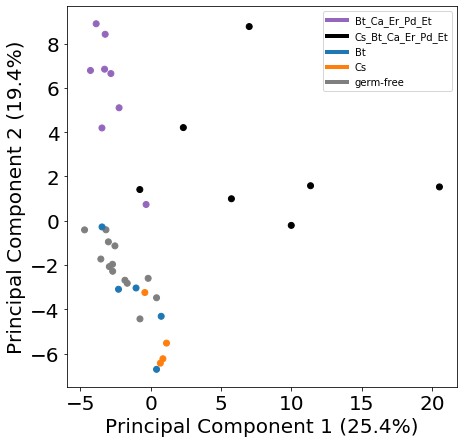

In [15]:
pcaplot = PCAPlot(fold_change_matrix_mode_collapsed, 
                  metadata, 
                  ['Bt_Ca_Er_Pd_Et', 'Cs_Bt_Ca_Er_Pd_Et', 'Bt', 'Cs', 'germ-free'], 
                  ['serum'])

pcaplot.plot_components([1, 2])

In [16]:
calculate_permanova(fold_change_matrix_mode_collapsed, 
                    metadata, 
                    ['Bt_Ca_Er_Pd_Et', 'Cs_Bt_Ca_Er_Pd_Et', 'Bt', 'Cs', 'germ-free'],
                    ['serum'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      37
number of groups                  5
test statistic             4.692003
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

### PCA: separation by colonization states of all urine samples

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd00c44cd0>)

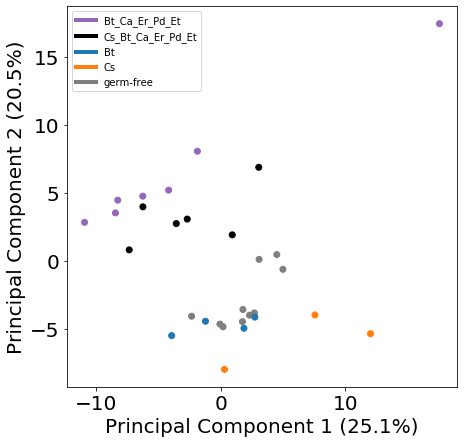

In [17]:
pcaplot = PCAPlot(fold_change_matrix_mode_collapsed, 
                  metadata, 
                  ['Bt_Ca_Er_Pd_Et', 'Cs_Bt_Ca_Er_Pd_Et', 'Bt', 'Cs', 'germ-free'], 
                  ['urine'])

pcaplot.plot_components([1, 2])

In [18]:
calculate_permanova(fold_change_matrix_mode_collapsed, 
                    metadata, 
                    ['Bt_Ca_Er_Pd_Et', 'Cs_Bt_Ca_Er_Pd_Et', 'Bt', 'Cs', 'germ-free'],
                    ['urine'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  5
test statistic              8.84775
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

### PCA: separation by colonization states of all caecal samples

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd00ca4750>)

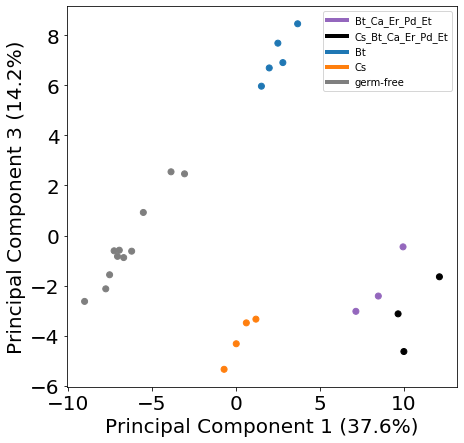

In [19]:
pcaplot = PCAPlot(fold_change_matrix_mode_collapsed, 
                  metadata, 
                  ['Bt_Ca_Er_Pd_Et', 'Cs_Bt_Ca_Er_Pd_Et', 'Bt', 'Cs', 'germ-free'], 
                  ['caecal'])

pcaplot.plot_components([1, 3])

In [20]:
calculate_permanova(fold_change_matrix_mode_collapsed, 
                    metadata, 
                    ['Bt_Ca_Er_Pd_Et', 'Cs_Bt_Ca_Er_Pd_Et', 'Bt', 'Cs', 'germ-free'],
                    ['caecal'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      26
number of groups                  5
test statistic            22.355922
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

### PCA: separation by colonization states of all fecal samples

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdce1f4e7d0>)

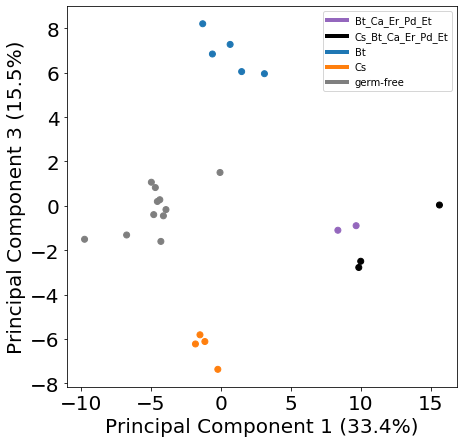

In [21]:
pcaplot = PCAPlot(fold_change_matrix_mode_collapsed, 
                  metadata, 
                  ['Bt_Ca_Er_Pd_Et', 'Cs_Bt_Ca_Er_Pd_Et', 'Bt', 'Cs', 'germ-free'], 
                  ['feces'])

pcaplot.plot_components([1, 3])

In [22]:
calculate_permanova(fold_change_matrix_mode_collapsed, 
                    metadata, 
                    ['Bt_Ca_Er_Pd_Et', 'Cs_Bt_Ca_Er_Pd_Et', 'Bt', 'Cs', 'germ-free'],
                    ['feces'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      25
number of groups                  5
test statistic            26.335465
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

# Compute statistics

Statistical calculation is conducted to output a set of p-values and corrected p-values using Student's t-test with Benjamini-Hochberg corrections for multiple comparisons. Both types of p values are reported on a per-metabolite and per sample-type basis. See the supporting code in `calculate_stats_sig_with_correction.py`.

### p-value calculation for serum metabolites

In [23]:
from calculate_stats_sig_with_correction import calculate_pvalues

colonizations = ['Bt', 'Cs', 'Cs_Bt_Ca_Er_Pd_Et']
sample_type = 'serum'

matrix = fold_change_matrix_mode_collapsed.join(metadata[['experiment', 'sample_type', 'colonization']])
matrix = matrix[matrix['colonization'].isin(colonizations + ['germ-free']) & (matrix['sample_type'] == sample_type)]

serum_pvalues = calculate_pvalues(matrix,
                                  colonizations=colonizations,
                                  sample_type=sample_type)

serum_pvalues

/Users/shuohan/anaconda3/envs/metabolomics-paper/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,colonization,fc_value_avg,pvalue,pvalue_corrected
"1,6-ANHYDRO-B-GLUCOSE",Bt,0.268494,0.037773,0.119706
"1,6-ANHYDRO-B-GLUCOSE",Cs,0.107431,0.325522,0.527849
"1,6-ANHYDRO-B-GLUCOSE",Cs_Bt_Ca_Er_Pd_Et,0.561277,0.003962,0.026680
1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID,Bt,-0.228514,0.150142,0.300983
1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID,Cs,0.106512,0.313578,0.515848
...,...,...,...,...
VITAMIN D3,Bt,-0.260740,0.276635,0.475018
VITAMIN D3,Cs,0.576046,0.051344,0.141854
VITAMIN D3,Cs_Bt_Ca_Er_Pd_Et,-2.872654,0.264261,0.457415
XANTHOSINE,Bt,0.076053,0.760251,0.848881


### p-value calculation for urine metabolites

In [24]:
colonizations = ['Bt', 'Cs', 'Cs_Bt_Ca_Er_Pd_Et']
sample_type = 'urine'

matrix = fold_change_matrix_mode_collapsed.join(metadata[['experiment', 'sample_type', 'colonization']])
matrix = matrix[matrix['colonization'].isin(colonizations + ['germ-free']) & (matrix['sample_type'] == sample_type)]

urine_pvalues = calculate_pvalues(matrix,
                                  colonizations=colonizations,
                                  sample_type=sample_type)

urine_pvalues

,colonization,fc_value_avg,pvalue,pvalue_corrected
"1,5-ANHYDRO-GLUCITOL",Bt,-0.201690,0.381043,0.574778
"1,5-ANHYDRO-GLUCITOL",Cs,-4.526651,0.112181,0.271140
"1,6-ANHYDRO-B-GLUCOSE",Bt,-0.619329,0.044257,0.139221
"1,6-ANHYDRO-B-GLUCOSE",Cs,-0.542292,0.210193,0.402331
"1,6-ANHYDRO-B-GLUCOSE",Cs_Bt_Ca_Er_Pd_Et,-0.520852,0.012693,0.060655
...,...,...,...,...
UROCANIC ACID,Cs_Bt_Ca_Er_Pd_Et,-0.415253,0.214305,0.406531
XANTHINE,Cs_Bt_Ca_Er_Pd_Et,3.916675,0.006015,0.035861
XANTHURENIC ACID,Bt,0.340310,0.116792,0.279699
XANTHURENIC ACID,Cs,0.341337,0.309880,0.507813


### p-value calculation for caecal metabolites

In [25]:
colonizations = ['Bt', 'Cs', 'Cs_Bt_Ca_Er_Pd_Et']
sample_type = 'caecal'

matrix = fold_change_matrix_mode_collapsed.join(metadata[['experiment', 'sample_type', 'colonization']])
matrix = matrix[matrix['colonization'].isin(colonizations + ['germ-free']) & (matrix['sample_type'] == sample_type)]

caecal_pvalues = calculate_pvalues(matrix,
                                   colonizations=colonizations,
                                   sample_type=sample_type)

caecal_pvalues

,colonization,fc_value_avg,pvalue,pvalue_corrected
"1,5,6,7-TETRAHYDRO-4H-INDOL-4-ONE",Cs_Bt_Ca_Er_Pd_Et,1.361762,2.392676e-02,3.917042e-02
"1,6-ANHYDRO-B-GLUCOSE",Bt,-0.586402,5.011306e-05,1.968958e-04
"1,6-ANHYDRO-B-GLUCOSE",Cs,-0.256308,2.929977e-02,4.733040e-02
"1,6-ANHYDRO-B-GLUCOSE",Cs_Bt_Ca_Er_Pd_Et,-0.525554,2.571136e-03,5.735612e-03
1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID,Bt,-0.698444,7.222790e-05,2.649807e-04
...,...,...,...,...
XANTHINE,Bt,0.301043,2.063355e-01,2.598829e-01
XANTHINE,Cs,-1.295509,1.118248e-02,1.991266e-02
XANTHURENIC ACID,Bt,4.713533,2.094824e-10,1.159771e-08
XANTHURENIC ACID,Cs,0.545207,1.044059e-02,1.889770e-02


# Visualize fold-change values

Violin plots are generated to visualize metabolites associated with a specific colonization state (e.g mono-association) in a given sample type (e.g. serum). These plots use the p-value calculations above to filter significantly regulated metabolites (>= 4 folds) using t-test with Benjamini-Hochberg corrections for multiple comparisons (P < 0.5) for a given sample type.


In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

def get_significant_pvalues(pvalues):
    return pvalues[(pvalues['fc_value_avg'] >= 2) & (pvalues['pvalue_corrected'] < 0.05)]

def get_label_for_colonizations_include_six_member(colonizations):
    if 'Cs_Bt_Ca_Er_Pd_Et' not in colonizations:
        return None

    if 'Bt' in colonizations:
        return 'Bt'
    elif 'Cs' in colonizations:
        return 'Cs'

    return None

def plot_data(metabolite_labels):
    data = filtered_fc_matrix.melt(id_vars=['colonization'], var_name='metabolite')

    data = data.merge(metabolite_labels, how='left', left_on='metabolite', right_index=True)
    data = data[data['label'].notnull()]

    germfree_data = fc_matrix[(fc_matrix['sample_type'] == sample_type) & (fc_matrix['colonization'] == 'germ-free')] \
        .drop(columns=['sample_type']) \
        .melt(id_vars=['colonization'], var_name='metabolite')

    germfree_data = germfree_data.merge(metabolite_labels, how='left', left_on='metabolite', right_index=True)
    germfree_data = germfree_data[germfree_data['label'].notnull()]

    all_data = pd.concat([data, germfree_data], sort=False)

    #print(all_data)

    fig, ax = plt.subplots(1, 1, figsize=(4, 4.4))

    sns.violinplot(x='colonization',
                        y='value',
                        data=all_data,
                        order=['germ-free'] + colonizations,
                        inner='quartile',
                        color='1.0',
                        linewidth=1,
                        scale='count',
                        ax=ax)

    sns.swarmplot(x='colonization',
                  y='value',
                  data=all_data,
                  order=['germ-free'] + colonizations,
                  hue_order=['Bt', 'Cs'],
                  size=2.0,
                  alpha=1,
                  hue='label',
                  palette=color_palette,
                  ax=ax)

    ax.axhline(y=0, c='k', linestyle=':', linewidth=0.5, zorder=10)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[0:], labels=labels[0:], loc='lower right', bbox_to_anchor=(1, 1))

    ax.set_xlabel('Colonization')
    ax.set_xticklabels(['Germ-free', 'Bt', 'Cs', 'Six-member'])

    ax.set_ylabel('Relative fold change vs. germ-free control (log2)')
    
    plt.tight_layout()

### Violin plot: serum metabolite associated with distinct colonization states

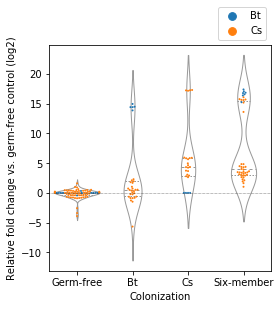

In [27]:
fc_matrix = fold_change_matrix_mode_collapsed
sample_type = 'serum'
colonizations = ['Bt', 'Cs', 'Cs_Bt_Ca_Er_Pd_Et']

color_palette = {
    'Bt': 'tab:blue',
    'Cs': 'tab:orange',
    'Six-member community (+Cs, +Bt)': 'k',
    'None': 'grey'
}

fc_matrix = fc_matrix \
    .join(metadata[['sample_type', 'colonization']])

filtered_fc_matrix = fc_matrix[(fc_matrix['sample_type'] == sample_type) & fc_matrix['colonization'].isin(colonizations)] \
    .drop(columns=['sample_type'])

serum_pvalues.index = serum_pvalues.index.set_names('metabolite')
sig_serum_pvalues = get_significant_pvalues(serum_pvalues)
sig_serum_pvalues = sig_serum_pvalues.reset_index()

#print(filtered_fc_matrix)
#print(sig_serum_pvalues)

colonizations_by_metabolite = sig_serum_pvalues.groupby('metabolite')['colonization'].apply(list)

#print(colonizations_by_metabolite)

metabolite_labels = colonizations_by_metabolite \
    .apply(lambda colonizations: get_label_for_colonizations_include_six_member(colonizations)) \
    .rename('label')

plot_data(metabolite_labels)

### Violin plot: urine metabolite associated with distinct colonization states

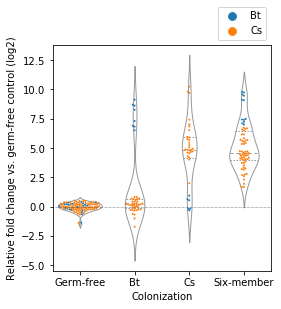

In [28]:
fc_matrix = fold_change_matrix_mode_collapsed
sample_type = 'urine'
colonizations = ['Bt', 'Cs', 'Cs_Bt_Ca_Er_Pd_Et']

color_palette = {
    'Bt': 'tab:blue',
    'Cs': 'tab:orange',
    'Six-member community (+Cs, +Bt)': 'k',
    'None': 'grey'
}

fc_matrix = fc_matrix \
    .join(metadata[['sample_type', 'colonization']])

filtered_fc_matrix = fc_matrix[(fc_matrix['sample_type'] == sample_type) & fc_matrix['colonization'].isin(colonizations)] \
    .drop(columns=['sample_type'])

urine_pvalues.index = urine_pvalues.index.set_names('metabolite')
sig_urine_pvalues = get_significant_pvalues(urine_pvalues)
sig_urine_pvalues = sig_urine_pvalues.reset_index()

#print(filtered_fc_matrix)
#print(sig_serum_pvalues)

colonizations_by_metabolite = sig_urine_pvalues.groupby('metabolite')['colonization'].apply(list)

#print(colonizations_by_metabolite)

metabolite_labels = colonizations_by_metabolite \
    .apply(lambda colonizations: get_label_for_colonizations_include_six_member(colonizations)) \
    .rename('label')

plot_data(metabolite_labels)